# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import tempfile
import pandapower as pp
from pandapower.control import ConstControl
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries

In [2]:
def timeseries_example(output_dir):
    # 1. create test net
    net = simple_test_net()

    # 2. create (random) data source
    n_timesteps = 24
    profiles, ds = create_data_source(n_timesteps)
    # 3. create controllers (to control P values of the load and the sgen)
    net=create_controllers(net, ds)
    print(net.controller)

    # time steps to be calculated. Could also be a list with non-consecutive time steps
    time_steps = range(0, n_timesteps)

    # 4. the output writer with the desired results to be stored to files.
    ow = create_output_writer(net, time_steps, output_dir=output_dir)

    # 5. the main time series function
    run_timeseries(net, time_steps)

In [3]:
def simple_test_net():
    """
    simple net that looks like:

    ext_grid b0---b1 trafo(110/20) b2----b3 load
                                    |
                                    |
                                    b4 sgen
    """
    net = pp.create_empty_network()
    pp.set_user_pf_options(net, init_vm_pu = "flat", init_va_degree = "dc", calculate_voltage_angles=True)

    b0 = pp.create_bus(net, 110)
    b1 = pp.create_bus(net, 110)
    b2 = pp.create_bus(net, 20)
    b3 = pp.create_bus(net, 20)
    b4 = pp.create_bus(net, 20)

    pp.create_ext_grid(net, b0)
    pp.create_line(net, b0, b1, 10, "149-AL1/24-ST1A 110.0")
    pp.create_transformer(net, b1, b2, "25 MVA 110/20 kV", name='tr1')
    pp.create_line(net, b2, b3, 10, "184-AL1/30-ST1A 20.0")
    pp.create_line(net, b2, b4, 10, "184-AL1/30-ST1A 20.0")

    pp.create_load(net, b2, p_mw=20., q_mvar=10., name='load1')
    pp.create_sgen(net, b4, p_mw=20., q_mvar=0.15, name='sgen1')

    return net

In [4]:
net = simple_test_net()
pp.runpp(net)
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-1.675619,-13.913027
1,0.994962,0.097296,0.000000,0.000000
2,0.926385,-150.246314,20.000000,10.000000
3,0.926436,-150.247834,0.000000,0.000000
4,0.991933,-139.941153,-20.000000,-0.150000


In [5]:
def create_data_source(n_timesteps=10):
    profiles = pd.DataFrame()
    profiles['load1_p'] = np.random.random(n_timesteps) * 20.
    profiles['sgen1_p'] = np.random.random(n_timesteps) * 20.

    ds = DFData(profiles)

    return profiles, ds

In [6]:
profiles, ds = create_data_source(10)
profiles

,load1_p,sgen1_p
0,0.286091,7.266102
1,10.491717,13.488743
2,3.781179,19.012929
3,13.648231,3.789404
4,10.758103,17.633152
5,9.641633,16.745960
6,18.620505,11.769883
7,12.537390,18.167846
8,2.278865,6.544755
9,3.690533,11.474022


In [7]:
def create_controllers(net, ds):
    ConstControl(net, element='load', variable='p_mw', element_index=[0],
                 data_source=ds, profile_name=["load1_p"])
    ConstControl(net, element='sgen', variable='p_mw', element_index=[0],
                 data_source=ds, profile_name=["sgen1_p"])
    return net

In [8]:
def create_output_writer(net, time_steps, output_dir):
    ow = OutputWriter(net, time_steps, output_path=output_dir, output_file_type=".xlsx", log_variables=list())
    # these variables are saved to the harddisk after / during the time series loop
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_line', 'i_ka')
    return ow

In [9]:
output_dir = os.path.join(tempfile.gettempdir(), "time_series_example")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
timeseries_example(output_dir)

Results can be found in your local temp folder: C:\Users\panto\AppData\Local\Temp\time_series_example
                     object  in_service  order level  initial_run  \
0  ConstControl [load.p_mw]        True   -1.0    -1        False   
1  ConstControl [sgen.p_mw]        True   -1.0    -1        False   

                                          recycle  
0  {'trafo': False, 'gen': False, 'bus_pq': True}  
1  {'trafo': False, 'gen': False, 'bus_pq': True}  


100%|██████████| 24/24 [00:00<00:00, 141.88it/s]


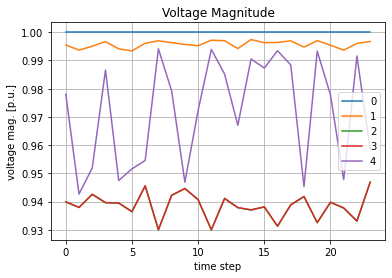

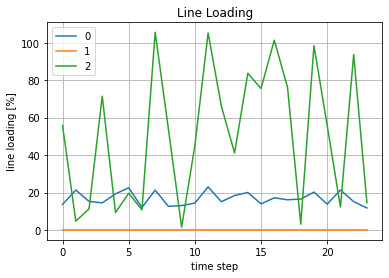

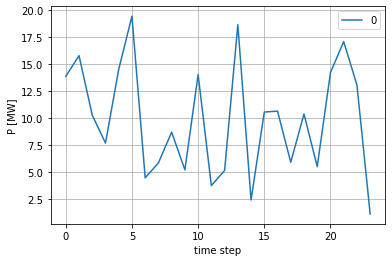

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline  

# voltage results
vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)
vm_pu.plot(label="vm_pu")
plt.xlabel("time step")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude")
plt.grid()
plt.show()

# line loading results
ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)
line_loading.plot(label="line_loading")
plt.xlabel("time step")
plt.ylabel("line loading [%]")
plt.title("Line Loading")
plt.grid()
plt.show()

# load results
load_file = os.path.join(output_dir, "res_load", "p_mw.xlsx")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="load")
plt.xlabel("time step")
plt.ylabel("P [MW]")
plt.grid()
plt.show()